# Comparison of neural network models for digit recognition

Mohammed Khalil  
July 7th, 2025

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier

from tensorflow.keras  import Model
from tensorflow.keras.models  import Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, MaxPooling2D, Conv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.datasets import mnist

2025-08-14 16:36:38.951640: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-14 16:36:38.970613: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI AVX_VNNI_INT8 AVX_NE_CONVERT FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# dataset

the MNIST dataset contains 70,000 handwritten digits (0-9), with each image being 28x28 pixels, each pixel value (0-255) represents the grayscale intensity

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

# normalize data by dividing by 255 for faster convergence during training
gray_scale = 255
X_train = X_train.astype('float32') / gray_scale
X_test = X_test.astype('float32') / gray_scale

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


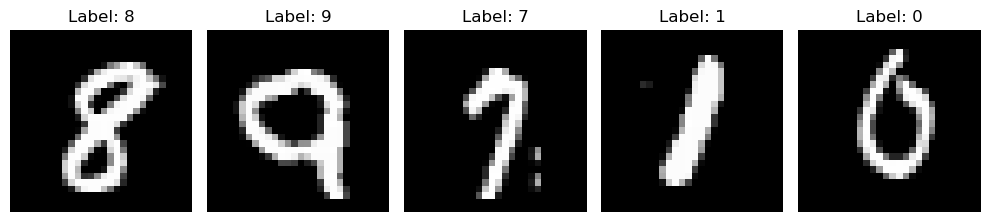

In [3]:
# Print 5 random images
plt.figure(figsize=(10, 5))
idx = 1
for i in np.random.randint(1,X_train.shape[0],5).tolist():
    plt.subplot(1, 5, idx)
    plt.imshow(X_train[i], cmap='gray')
    plt.title(f"Label: {y_train[i]}")
    plt.axis('off')
    idx += 1
plt.tight_layout()
plt.show()

In [4]:
# reshape images
X_train_vec = X_train.reshape([X_train.shape[0], X_train.shape[1] * X_train.shape[2]])
X_test_vec = X_test.reshape([X_test.shape[0], X_test.shape[1] * X_test.shape[2]])
X_train_vec.shape

(60000, 784)

In [5]:
# Make images with shape (28, 28, 1) 
input_shape = (28, 28, 1)

X_train_exp = np.expand_dims(X_train, -1)
X_test_exp = np.expand_dims(X_test, -1)
print(X_train_exp.shape)

(60000, 28, 28, 1)


In [6]:
# convert class vectors to binary class matrices
num_classes = 10
y_train_exp = to_categorical(y_train, num_classes)
y_test_exp = to_categorical(y_test, num_classes)
y_train_exp.shape

(60000, 10)

# multi-layer perceptron (MLP)

## MLP with sklearn

In [7]:
%%time
# MLPClassifier with default parameters (hidden_layer_sizes=(100,), activation='relu', solver='adam', 
#    learning_rate_init=0.001, alpha=0.0001, max_iter=200, momentum=0.9,)
model = MLPClassifier()
model.fit(X_train_vec, y_train)
y_pred = model.predict(X_test_vec)

print(f"Using MLPClassifier with the default parameters gives an accuracy of {accuracy_score(y_pred, y_test)}")

Using MLPClassifier with the default parameters gives an accuracy of 0.9804
CPU times: user 8min 22s, sys: 161 ms, total: 8min 23s
Wall time: 22.1 s


In [8]:
# extract wrong classifications
wrong_class = y_test != y_pred
X_test_wrong = X_test[wrong_class]
y_test_wrong = y_test[wrong_class]
y_pred_wrong = y_pred[wrong_class]
X_test_wrong.shape

(196, 28, 28)

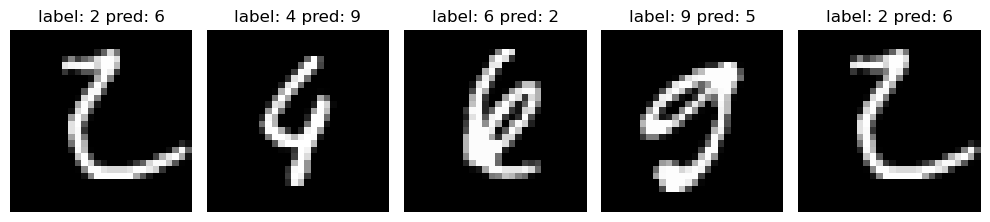

In [9]:
# Print 5 random wrong classifications
plt.figure(figsize=(10, 5))
idx = 1
for i in np.random.randint(1,X_test_wrong.shape[0],5).tolist():
    plt.subplot(1, 5, idx)
    plt.imshow(X_test_wrong[i], cmap='gray')
    plt.title(f"label: {y_test_wrong[i]} pred: {y_pred_wrong[i]}")
    plt.axis('off')
    idx += 1
plt.tight_layout()
plt.show()

In [ ]:
%%time
# use RandomizedSearchCV with reduced train size to optimize hyperparameters
parameters = {'hidden_layer_sizes':[100, 200, 300],
              'alpha': [0.001, 0.01], 
              'max_iter': [200, 400, 600], 
              'learning_rate_init':[0.001, 0.01]}

model = MLPClassifier()
clf = RandomizedSearchCV(estimator=model, param_distributions=parameters, cv=5, n_jobs=-1)
clf.fit(X_train_vec[:20000], y_train[:20000])

print("The best parameter values found are:\n")
best_params = clf.best_params_
best_params

The best parameter values found are:

CPU times: user 8min 1s, sys: 243 ms, total: 8min 2s
Wall time: 1min 33s


{'max_iter': 600,
 'learning_rate_init': 0.001,
 'hidden_layer_sizes': 300,
 'alpha': 0.01}

In [11]:
%%time
# MLPClassifier with tuned parameters trained on full train data
model = MLPClassifier(**best_params)
model.fit(X_train_vec, y_train)
y_pred = model.predict(X_test_vec)

print(f"Using MLPClassifier with the tuned parameters gives an accuracy of {accuracy_score(y_pred, y_test)}")

Using MLPClassifier with the tuned parameters gives an accuracy of 0.9833
CPU times: user 20min 7s, sys: 78.9 ms, total: 20min 7s
Wall time: 49.8 s


In [12]:
# wrong classifications
wrong_class = y_test != y_pred
X_test_wrong = X_test[wrong_class]
y_test_wrong = y_test[wrong_class]
y_pred_wrong = y_pred[wrong_class]
X_test_wrong.shape

(167, 28, 28)

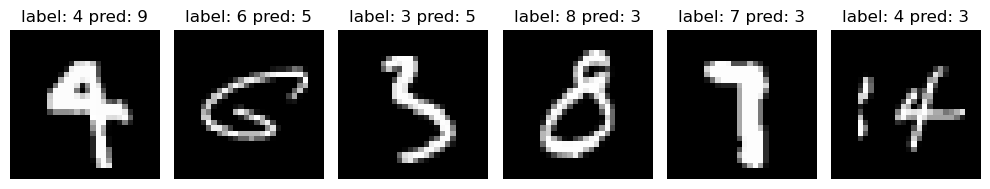

In [13]:
# Print random wrong classifications
plt.figure(figsize=(10, 5))
idx = 1
for i in np.random.randint(1,X_test_wrong.shape[0],6).tolist():
    plt.subplot(1, 6, idx)
    plt.imshow(X_test_wrong[i], cmap='gray')
    plt.title(f"label: {y_test_wrong[i]} pred: {y_pred_wrong[i]}")
    plt.axis('off')
    idx += 1
plt.tight_layout()
plt.show()

## MLP with Keras

In [14]:
# sequential model with 2 hidden layers
model = Sequential([
    Flatten(input_shape=(28, 28)), # Reshapes 2D input (28x28 pixels) into a 1D array
    Dense(256, activation='relu'),  
    Dense(128, activation='relu'), 
    Dense(10, activation='softmax'), # output with softmax for classification
])

model.summary()

/home/mkhalil/anaconda3/envs/mlcpu/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 235,146 (918.54 KB)

 Trainable params: 235,146 (918.54 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# compile model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [16]:
%%time
# train model
mod = model.fit(X_train, y_train, epochs=50, 
          batch_size=1000, 
          validation_split=0.25)

Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8120 - loss: 0.7235 - val_accuracy: 0.9176 - val_loss: 0.2792
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9288 - loss: 0.2430 - val_accuracy: 0.9427 - val_loss: 0.2049
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9494 - loss: 0.1775 - val_accuracy: 0.9519 - val_loss: 0.1710
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9594 - loss: 0.1412 - val_accuracy: 0.9560 - val_loss: 0.1549
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9673 - loss: 0.1157 - val_accuracy: 0.9597 - val_loss: 0.1364
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9722 - loss: 0.0962 - val_accuracy: 0.9647 - val_loss: 0.1232
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9778 - loss: 0.0797 - val_accuracy: 0.9663 - val_loss: 0.1149
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9810 - loss: 0.0685 - val_accuracy: 0.9663 - val_loss

In [17]:
# evaluate model
results = model.evaluate(X_test, y_test, verbose=0)
print('Test loss, Test accuracy:', results)

Test loss, Test accuracy: [0.0894480049610138, 0.9790999889373779]


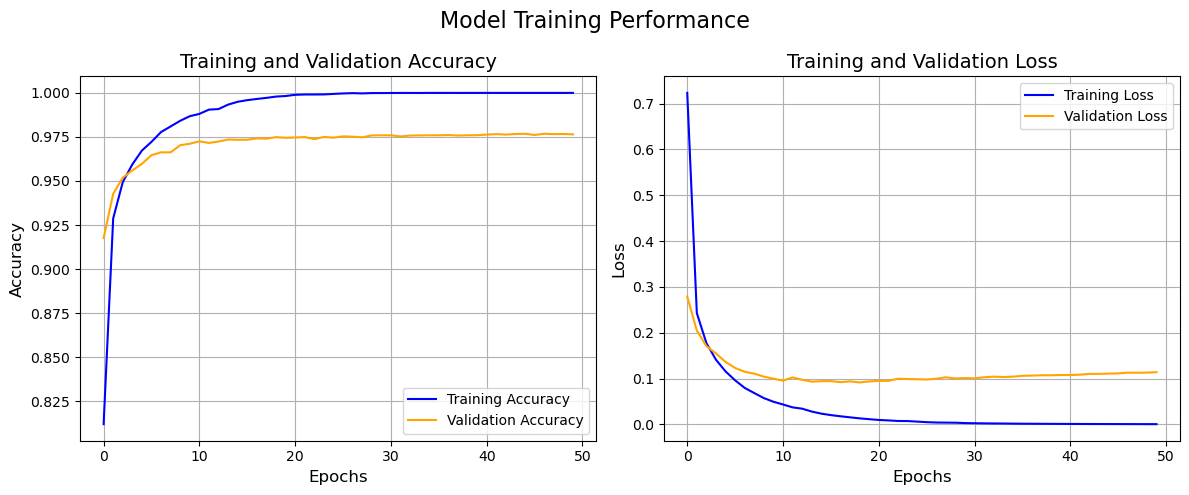

In [18]:
# Visualizing Training and Validation Loss VS Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(mod.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(mod.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Training and Validation Accuracy', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(mod.history['loss'], label='Training Loss', color='blue')
plt.plot(mod.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training and Validation Loss', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.grid(True)

plt.suptitle("Model Training Performance", fontsize=16)
plt.tight_layout()
plt.show()

# Convolutional neural networks

model parameters from
https://keras.io/examples/vision/mnist_convnet/

In [19]:
model = Sequential(
    [
        Input(shape=input_shape),
        Conv2D(32, kernel_size=(3, 3), activation="relu"),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, kernel_size=(3, 3), activation="relu"),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dropout(0.5),
        Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │        16,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,826 (136.04 KB)

 Trainable params: 34,826 (136.04 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
%%time

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model.fit(X_train_exp, y_train_exp, batch_size=125, epochs=15, validation_split=0.1)

Epoch 1/15
432/432 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8943 - loss: 0.3518 - val_accuracy: 0.9780 - val_loss: 0.0830
Epoch 2/15
432/432 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9658 - loss: 0.1113 - val_accuracy: 0.9838 - val_loss: 0.0555
Epoch 3/15
432/432 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9738 - loss: 0.0842 - val_accuracy: 0.9877 - val_loss: 0.0461
Epoch 4/15
432/432 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9780 - loss: 0.0696 - val_accuracy: 0.9868 - val_loss: 0.0426
Epoch 5/15
432/432 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9810 - loss: 0.0609 - val_accuracy: 0.9903 - val_loss: 0.0367
Epoch 6/15
432/432 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9818 - loss: 0.0567 - val_accuracy: 0.9908 - val_loss: 0.0361
Epoch 7/15
432/432 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9834 - loss: 0.0513 - val_accuracy: 0.9888 - val_loss: 0.0373
Epoch 8/15
432/432 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9853 - loss: 0.0474 - val_accuracy: 0.

In [21]:
score = model.evaluate(X_test_exp, y_test_exp, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.024163030087947845
Test accuracy: 0.9914000034332275
